<a href="https://colab.research.google.com/github/BojanMakivic/Predicting-fitness-level-of-cancer-survivors/blob/master/Fastai_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Update fastai library

In [ ]:
 !pip install fastai --upgrade

# Mount the google drive
Here is link about how to mount google drive to Google Colab: https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Libraries

In [3]:
# Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd

# FastAi
import fastai
from fastai import *
from fastai.vision.all import *
from fastai.vision.data import *

# PyTorch
import torch

# Figures plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Imbalanced data
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
from google.colab import files
import io

df = pd.read_excel('/content/drive/MyDrive/Data.xlsx')
df = pd.DataFrame(df)

In [5]:
df['Level']=np.where(df['Level']=="Bad",3,np.where(df['Level']=="Moderate",2,1))
df['Sex']=np.where(df['Sex']=="W",0,1)

In [ ]:
df

In [6]:
# Function
def bmi(bw,bh):
    return bw/((bh/100)*(bh/100))

In [7]:
# Adding a new column
df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 

In [8]:
np.random.seed(42) 
del df['Norm']
del df['Type']
#del df['Level']
del df['Wmax'] # continuous

In [ ]:
np.array(df)

## PREPARING TRAINING AND TEST DATASET

In [9]:
from sklearn.model_selection import train_test_split

train_labels = df["Level"].copy()       # Save a copy of label variable
train_sets = df.drop("Level", axis=1)    # Drop label variable from training se

In [28]:
train_labels

0       1
1       1
2       1
3       2
4       1
       ..
2914    3
2915    3
2916    3
2917    3
2918    3
Name: Level, Length: 2919, dtype: int64

In [ ]:
np.array(train_sets)

In [ ]:
train_num = train_sets.to_numpy()
train_num

In [15]:
train_num = train_sets.drop(["Sex"], axis=1)  # Keep only numerical variables

## PIPELINE

In [16]:
# Pipline to scale numerical variables and transform categorical variable (Sex) into binary

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
        ('std_scaler', MinMaxScaler()),])
train_transf = pipeline.fit_transform(train_num)

In [ ]:
train_transf

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = list(train_num) #train_num
cat_attribs = ["Sex"]

full_pipeline = ColumnTransformer([
        ("num", pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),])

train_prepared = full_pipeline.fit_transform(train_sets)
train_prepared

# Handling imbalanced datase with SMOTENC class.

### The three classes of outcome variable are not equaly represented.

In [19]:
from imblearn.over_sampling import SMOTENC
X, y = train_prepared, train_labels
print('Original dataset shape %s' % Counter(y))

sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=15)

train_prepared, train_labels = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(train_labels))

Original dataset shape Counter({1: 973, 2: 622, 3: 117})
Resampled dataset shape Counter({1: 973, 2: 973, 3: 973})


In [20]:
len(train_labels)

2919

# Creating Images and preparing for analysis

### Transforming outcome variable into images and storing them in the list.

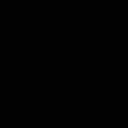

In [21]:
from PIL import Image

list_labels = []

labels = train_labels
for i in labels:
    img = Image.fromarray(np.array([[i]], dtype=np.uint16), 'L')
    list_labels.append(img.resize((128,128)))
list_labels[3]

### Transforming predictor variables into images and storing them in the list.

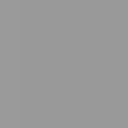

In [22]:
np.random.seed(369)
from PIL import Image
import PIL
import fastai

list_train = []

for i in train_prepared:
    img = Image.fromarray(np.array([i]), 'L')
    list_train.append(img.resize((128,128)))
list_train[7]

In [23]:
len(list_train)

2919

Checking the first number of the image array and print it.

In [24]:
sum(np.array(list_labels[4], dtype=np.uint16))[1]

128

Creating save directory in the google drive, where the images will be stored

In [ ]:
save_dir = '/content/drive/MyDrive/Fastai_images'

With this while loop, the images created from predictor variables are matched with images created from response variable and stored with the name of matched response variable (Good, Moderate or Bad).

In [ ]:
#Saving images
length = len(list_train)
i = 0

while i < length:
    if sum(np.array(list_labels[i], dtype=np.uint16))[1]==128:
        list_train[i].save(f'{save_dir}/Good/G_{i}.png')
    elif sum(np.array(list_labels[i], dtype=np.uint16))[1]==384:
        list_train[i].save(f'{save_dir}/Bad/B_{i}.png')
    else:
        list_train[i].save(f'{save_dir}/Moderate/M_{i}.png')
    i += 1

# Model

In [ ]:
dls = ImageDataLoaders.from_folder(
    save_dir, get_image_files(save_dir), valid_pct=0.2, set_seed =42)

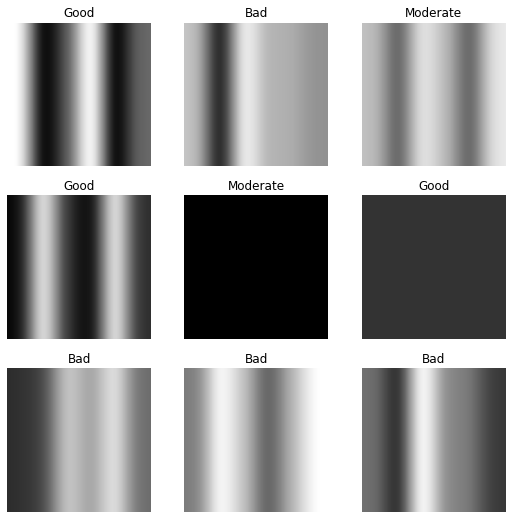

In [ ]:
dls.show_batch()

In [ ]:
simple_net = nn.Sequential(
    nn.Conv2d(10,10, kernel_size=5, padding=1), #nn.Linear
    nn.ReLU(),
    nn.Conv2d(40,64, kernel_size=5, padding=1), #nn.Linear
    nn.ReLU() 
)

In [ ]:
learn = cnn_learner(dls, resnet18, simple_net,
                metrics=[error_rate, accuracy,Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted'), RocAuc(average='weighted')])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

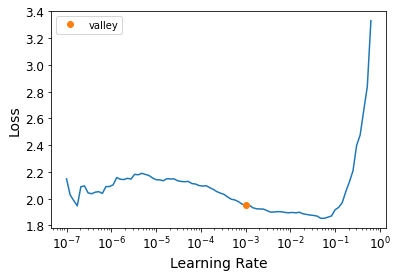

In [ ]:
lr = learn.lr_find(suggest_funcs=(valley))


In [ ]:
learn.fine_tune(1, lr.valley)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.654198,1.217958,0.430532,0.569468,0.541144,0.569468,0.541693,0.715298,00:03


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.641496,1.262442,0.394511,0.605489,0.570973,0.605489,0.563682,0.721721,00:03


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC 
src = []

for i in range(2,23):
  sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=i, n_jobs=-1)
  train_prepared, train_labels = sm.fit_resample(train_prepared, train_labels)
  dls = ImageDataLoaders.from_folder(
      save_dir, get_image_files(save_dir), valid_pct=0.2, set_seed =42)
  simple_net = nn.Sequential(
      nn.Conv2d(10,10, kernel_size=5, padding=1), #nn.Linear
      nn.ReLU(),
      nn.Conv2d(40,64, kernel_size=5, padding=1), #nn.Linear
      nn.ReLU() 
  )
  learn = cnn_learner(dls, resnet18, simple_net,
                    metrics=[error_rate, accuracy,Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted'), RocAuc(average='weighted')])
  lr = learn.lr_find(suggest_funcs=(valley))
  learn.fine_tune(3, lr.valley)

# Confusion matrix

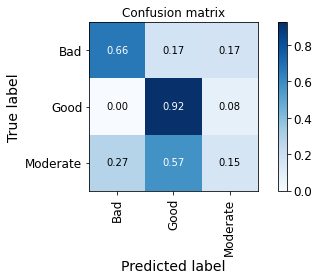

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=all)

plt.colorbar()
    
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()